### This notebook contains code for producing the results presented in the paper

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from semopy import Model
import semopy
import oulad_helper
from IPython.display import Image
from statsmodels.stats.proportion import proportions_ztest

In [4]:
from collections import Counter
from sklearn.preprocessing import binarize

from tqdm import tqdm
import pandas as pd
from os.path import join
from semopy.examples import political_democracy
from semopy import Model as semmodel
import semopy
from IPython.display import Image
import math
import seaborn as sns
from scipy import stats
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
from sklearn.metrics import f1_score, classification_report
from sklearn import feature_selection
from sklearn.decomposition import PCA, FactorAnalysis
import statsmodels
from sklearn.manifold import TSNE

In [5]:
import plot_helper_methods
import ml_helper_methods
from gradrev import GradientReversal
import oulad_helper

In [6]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as data_utils
from torch.nn import utils
from torch.autograd import Function
import torch.nn.functional as F
from torch.utils.data import DataLoader

import random

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [7]:
colors = ['teal','indianred','steelblue']
markers=['o','^','d','h','*','v','d','^','<']
linestyles=['-', '--', '-.', ':']
labelFont = 18
legendFont = 16
tickFont = 16

In [8]:
data_root='/data/rakhasan/edtech-data/OULAD/'
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
student_df = pd.read_csv(join(data_root,'student_df_preprocessed.csv'))
student_df.set_index('id_student', inplace=True)
student_df.head(2)

,id_student.1,code_module,code_presentation,id_student.1.1,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_num,disability_num,highest_education_num,final_result_num,age_num,previously_attempted
id_student,,,,,,,,,,,,,,,,,,,
11391,11391,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,0,0,3,1,3,False
28400,28400,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1,0,3,1,1,False


In [10]:
semester_feature_df = pd.read_csv(join(data_root,'semester-level-activity.csv')
semester_feature_df.set_index('row_id', inplace=True)
semester_feature_df.head(2)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,max_block_len,min_block_len,mean_block_len,var_block_len,gender_num,final_result_num,credits,highest_education,previously_attempted,age_num
row_id,,,,,,,,,,,,,,,,,,,,,
79461_CCC_2014B,0,0,0,0,34,0,45,0,0,0,...,3,1,1.500000,0.583333,0,0,90,2,False,1
2356809_BBB_2013J,0,0,0,0,139,2,95,0,3,8,...,11,1,5.333333,14.555556,1,1,60,2,False,0


In [11]:
semester_feature_df.groupby('age_num').count()/len(semester_feature_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,block_count,max_block_len,min_block_len,mean_block_len,var_block_len,gender_num,final_result_num,credits,highest_education,previously_attempted
age_num,,,,,,,,,,,,,,,,,,,,,
0,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,...,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645,0.305645
1,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,...,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355,0.694355


In [12]:
'''binarize education level'''
semester_feature_df['edu_bin'] = semester_feature_df.apply(lambda row: 
                                        row.highest_education<=1, axis=1)

In [13]:
semester_feature_df.groupby('edu_bin').count()/len(semester_feature_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,max_block_len,min_block_len,mean_block_len,var_block_len,gender_num,final_result_num,credits,highest_education,previously_attempted,age_num
edu_bin,,,,,,,,,,,,,,,,,,,,,
False,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,...,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078,0.592078
True,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,...,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922,0.407922


In [14]:
semester_level_preds = list(set(semester_feature_df.columns).difference(set([
                    'gender_num', 'final_result_num', 'credits', 'highest_education', 'edu_bin', 
                    'previously_attempted', 'blocks' , 'final_result', 'gender', 'age_num'])))
print(len(semester_level_preds))

65


In [15]:
semester_feature_df.groupby('final_result_num').count()#/len(semester_feature_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,max_block_len,min_block_len,mean_block_len,var_block_len,gender_num,credits,highest_education,previously_attempted,age_num,edu_bin
final_result_num,,,,,,,,,,,,,,,,,,,,,
0,11774,11774,11774,11774,11774,11774,11774,11774,11774,11774,...,11774,11774,11774,11774,11774,11774,11774,11774,11774,11774
1,13471,13471,13471,13471,13471,13471,13471,13471,13471,13471,...,13471,13471,13471,13471,13471,13471,13471,13471,13471,13471


In [16]:
semester_feature_df.groupby('gender_num').count()#/len(semester_feature_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,max_block_len,min_block_len,mean_block_len,var_block_len,final_result_num,credits,highest_education,previously_attempted,age_num,edu_bin
gender_num,,,,,,,,,,,,,,,,,,,,,
0,13374,13374,13374,13374,13374,13374,13374,13374,13374,13374,...,13374,13374,13374,13374,13374,13374,13374,13374,13374,13374
1,11871,11871,11871,11871,11871,11871,11871,11871,11871,11871,...,11871,11871,11871,11871,11871,11871,11871,11871,11871,11871


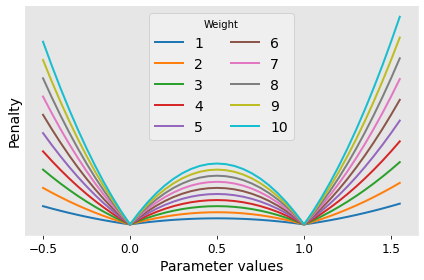

In [21]:
fig, ax= plt.subplots()
x=np.arange(-.5, 1.6, .05)
for i in range(1,11,1):
    y=np.abs(x**2-x)*(i)
    plt.plot(x,y, linewidth=2, label=i)

plt.xticks(np.arange(-.5,2,.5), fontsize=tickFont-4)
plt.xlabel('Parameter values', fontsize=labelFont-4)
plt.yticks([])
plt.ylabel('Penalty', fontsize=labelFont-4)


background=".9"
ax.set_facecolor(background)

plt.setp(ax.spines.values(), color=background)
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=background)
plt.legend(fontsize=labelFont-4, facecolor=".95", loc='upper center', ncol=2, title='Weight')
plt.tight_layout()
plt.savefig("/data/rakhasan/cost-func.pdf",dpi=600)
plt.show()

In [18]:
n_epochs=10

#### Baselines:How well the outcome can be predicted using all features

In [19]:
'''How well the outcome can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy(
    semester_feature_df, predictors = semester_level_preds, label = 'final_result_num', max_iter=100000)

        Accuracy:87.40
        Precision:[0.87353735 0.87442519]
        Recall:[0.84538328 0.89792953]
        F1:[0.85922975 0.88602151]
        support:[2296 2753]
Confusion matrix:
[[1941  355]
 [ 281 2472]]


LogisticRegression(C=1, max_iter=100000, penalty='none', random_state=0)

In [20]:
'''How well the gender can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy(
    semester_feature_df, predictors = semester_level_preds, label = 'gender_num', max_iter=10000)

        Accuracy:72.33
        Precision:[0.6959375  0.77068686]
        Recall:[0.84006035 0.5942452 ]
        F1:[0.7612374  0.67106193]
        support:[2651 2398]
Confusion matrix:
[[2227  424]
 [ 973 1425]]


LogisticRegression(C=1, max_iter=10000, penalty='none', random_state=0)

In [21]:
'''How well the age can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy( semester_feature_df, predictors = semester_level_preds, 
                                    label = 'age_num', average='weighted', class_weight=None, max_iter=10000)

        Accuracy:71.97
        Precision:0.6964028306109772
        Recall:0.7197464844523668
        F1:0.6696310825464666
        support:None
Confusion matrix:
[[ 330 1208]
 [ 207 3304]]


LogisticRegression(C=1, max_iter=10000, penalty='none', random_state=0)

In [22]:
'''How well the age can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy( semester_feature_df, predictors = semester_level_preds, 
                                            label = 'age_num', class_weight='balanced', 
                                            average='weighted', max_iter=10000)

        Accuracy:64.41
        Precision:0.6762506852801681
        Recall:0.6440879382055853
        F1:0.6548949836549094
        support:None
Confusion matrix:
[[ 874  664]
 [1133 2378]]


LogisticRegression(C=1, class_weight='balanced', max_iter=10000, penalty='none',
                   random_state=0)

### Custom models for gender

In [23]:
oulad_helper.train_outcome_predictor(data=semester_feature_df, predictors=semester_level_preds, 
                                     outcome_col='gender_num', batch_size = 10, n_epochs=15)

  2%|▏         | 32/2020 [00:00<00:06, 319.16it/s]  

EPOCH 1: train-loss:0.5639, val-loss:0.5251, val-accuracy= 0.7473


  1%|          | 20/2020 [00:00<00:10, 195.61it/s]  

EPOCH 2: train-loss:0.5253, val-loss:0.5305, val-accuracy= 0.7510


  1%|          | 24/2020 [00:00<00:08, 232.15it/s]  

EPOCH 3: train-loss:0.5202, val-loss:0.5210, val-accuracy= 0.7554


  2%|▏         | 39/2020 [00:00<00:05, 381.25it/s]  

EPOCH 4: train-loss:0.5135, val-loss:0.5193, val-accuracy= 0.7570


  1%|          | 23/2020 [00:00<00:08, 222.26it/s]  

EPOCH 5: train-loss:0.5113, val-loss:0.5116, val-accuracy= 0.7590


  1%|          | 21/2020 [00:00<00:09, 204.60it/s]  

EPOCH 6: train-loss:0.5065, val-loss:0.5186, val-accuracy= 0.7497


  1%|          | 23/2020 [00:00<00:08, 227.90it/s]  

EPOCH 7: train-loss:0.5048, val-loss:0.5065, val-accuracy= 0.7643


  1%|          | 21/2020 [00:00<00:09, 202.26it/s]  

EPOCH 8: train-loss:0.5019, val-loss:0.5134, val-accuracy= 0.7550


  1%|          | 23/2020 [00:00<00:08, 227.49it/s]  

EPOCH 9: train-loss:0.4998, val-loss:0.5059, val-accuracy= 0.7677


  1%|          | 20/2020 [00:00<00:10, 199.57it/s]  

EPOCH 10: train-loss:0.4992, val-loss:0.5128, val-accuracy= 0.7629


  1%|          | 21/2020 [00:00<00:09, 204.19it/s]  

EPOCH 11: train-loss:0.4975, val-loss:0.5020, val-accuracy= 0.7677


  1%|          | 21/2020 [00:00<00:09, 202.08it/s]  

EPOCH 12: train-loss:0.4959, val-loss:0.5040, val-accuracy= 0.7649


  1%|          | 23/2020 [00:00<00:09, 221.59it/s]  

EPOCH 13: train-loss:0.4953, val-loss:0.5074, val-accuracy= 0.7653


  1%|          | 21/2020 [00:00<00:09, 207.13it/s]  

EPOCH 14: train-loss:0.4929, val-loss:0.5128, val-accuracy= 0.7617


EPOCH 15: train-loss:0.4903, val-loss:0.5060, val-accuracy= 0.7645


[0.7472766884531591,
 0.7510398098633393,
 0.7553971083382848,
 0.7569815805109923,
 0.7589621707268767,
 0.7496533967122202,
 0.7643097643097643,
 0.7550009902951079,
 0.7676767676767676,
 0.7629233511586453,
 0.7676767676767676,
 0.7649039413745297,
 0.7653000594177065,
 0.7617349970291146,
 0.7645078233313527]

### Domain adaptation for gender

In [24]:
'Model with gradient reversal but not linear transform layer'
gr_model_gender = oulad_helper.FeatExtractorGR(dim_in = len(semester_level_preds))
domain_acc, class_acc, domain_loss, class_loss = oulad_helper.train_feat_transformer(
        data=semester_feature_df,predictors=semester_level_preds, outcome_col='final_result_num',
        sensitive_attr_col='gender_num', model=gr_model_gender, n_epochs=15, #l1_weight = .1, l2_weight = .1,
        ortho_weight = 0, lasso=True, l1_mul=1, l1_ann= False)

  1%|          | 17/2525 [00:00<00:15, 163.11it/s]

lambda_ : 0.3
training model with l1=0.0, l2=0.0, ortho=0


  1%|          | 18/2525 [00:00<00:14, 172.48it/s]  

EPOCH 1: domain loss=0.0694, class accuracy= 0.8339, domain accuracy=0.5738, l1 loss:0.000, l1_weight:0.0


  1%|          | 17/2525 [00:00<00:15, 162.53it/s]  

EPOCH 2: domain loss=0.0690, class accuracy= 0.8719, domain accuracy=0.5424, l1 loss:0.000, l1_weight:0.0


  1%|          | 17/2525 [00:00<00:15, 162.14it/s]  

EPOCH 3: domain loss=0.0691, class accuracy= 0.8774, domain accuracy=0.5340, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 159.60it/s]  

EPOCH 4: domain loss=0.0691, class accuracy= 0.8800, domain accuracy=0.5382, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 157.09it/s]  

EPOCH 5: domain loss=0.0688, class accuracy= 0.8838, domain accuracy=0.5526, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 157.78it/s]  

EPOCH 6: domain loss=0.0687, class accuracy= 0.8860, domain accuracy=0.5422, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 158.88it/s]  

EPOCH 7: domain loss=0.0690, class accuracy= 0.8856, domain accuracy=0.5428, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 158.37it/s]  

EPOCH 8: domain loss=0.0690, class accuracy= 0.8879, domain accuracy=0.5359, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 159.97it/s]  

EPOCH 9: domain loss=0.0688, class accuracy= 0.8868, domain accuracy=0.5432, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 159.87it/s]  

EPOCH 10: domain loss=0.0688, class accuracy= 0.8855, domain accuracy=0.5365, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:16, 151.33it/s]  

EPOCH 11: domain loss=0.0688, class accuracy= 0.8885, domain accuracy=0.5433, l1 loss:0.000, l1_weight:0.0


  1%|          | 17/2525 [00:00<00:15, 162.14it/s]  

EPOCH 12: domain loss=0.0689, class accuracy= 0.8892, domain accuracy=0.5330, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 157.38it/s]  

EPOCH 13: domain loss=0.0689, class accuracy= 0.8903, domain accuracy=0.5359, l1 loss:0.000, l1_weight:0.0


  1%|          | 16/2525 [00:00<00:15, 157.82it/s]  

EPOCH 14: domain loss=0.0689, class accuracy= 0.8907, domain accuracy=0.5380, l1 loss:0.000, l1_weight:0.0


EPOCH 15: domain loss=0.0690, class accuracy= 0.8919, domain accuracy=0.5327, l1 loss:0.000, l1_weight:0.0


### Train seperate models with censored features

In [90]:
'''extract sanitized features to train a separate model'''
tensor = torch.Tensor(semester_feature_df[semester_level_preds].values)
censored_feats = gr_model_gender.feature_extractor(tensor)
censored_df = pd.DataFrame(censored_feats.detach().numpy(), index=semester_feature_df.index)
censored_df['gender_num']=semester_feature_df.gender_num
censored_df['final_result_num']=semester_feature_df.final_result_num
censored_df.head(2)

,0,1,2,3,4,5,6,7,8,9,gender_num,final_result_num
row_id,,,,,,,,,,,,
79461_CCC_2014B,0.0,0.0,0.0,21.958075,0.0,3.45196,6.790876,0.0,0.0,1.189345,0,0
2356809_BBB_2013J,0.0,0.0,0.0,58.224491,0.0,0.00000,0.000000,0.0,0.0,0.000000,1,1


In [93]:
'''use simple logit model'''
ml_helper_methods.test_logit_model_accuracy(censored_df, predictors=range(10), 
                                            label='final_result_num', max_iter=100000)

ml_helper_methods.test_logit_model_accuracy(censored_df, predictors=range(10), 
                                            label='gender_num', max_iter=100000)

        Accuracy:89.30
        Precision:[0.91929322 0.87445008]
        Recall:[0.83841463 0.93861242]
        F1:[0.87699317 0.90539594]
        support:[2296 2753]
Confusion matrix:
[[1925  371]
 [ 169 2584]]
        Accuracy:52.55
        Precision:[0.53619075 0.50065531]
        Recall:[0.7125613  0.31859883]
        F1:[0.61192096 0.38939857]
        support:[2651 2398]
Confusion matrix:
[[1889  762]
 [1634  764]]


LogisticRegression(C=1, max_iter=100000, penalty='none', random_state=0)

### Train model using DA and constrained optimization

  1%|          | 14/2525 [00:00<00:19, 131.73it/s]

lambda_ : 0.3
training model with l1=1, l2=0.1, ortho=0


  0%|          | 12/2525 [00:00<00:21, 114.76it/s]  

EPOCH 1: domain loss=0.0721, class accuracy= 0.7882, domain accuracy=0.5156, l1 loss:50.349, l1_weight:2


  0%|          | 12/2525 [00:00<00:21, 114.80it/s]  

EPOCH 2: domain loss=0.0692, class accuracy= 0.8522, domain accuracy=0.5267, l1 loss:70.807, l1_weight:3


  0%|          | 11/2525 [00:00<00:22, 109.72it/s]  

EPOCH 3: domain loss=0.0691, class accuracy= 0.8544, domain accuracy=0.5281, l1 loss:69.854, l1_weight:4


  0%|          | 12/2525 [00:00<00:22, 111.11it/s]  

EPOCH 4: domain loss=0.0692, class accuracy= 0.8531, domain accuracy=0.5298, l1 loss:63.484, l1_weight:5


  0%|          | 11/2525 [00:00<00:23, 109.26it/s]  

EPOCH 5: domain loss=0.0692, class accuracy= 0.8534, domain accuracy=0.5298, l1 loss:51.135, l1_weight:6


  0%|          | 10/2525 [00:00<00:25, 97.01it/s]   

EPOCH 6: domain loss=0.0692, class accuracy= 0.8528, domain accuracy=0.5297, l1 loss:31.270, l1_weight:7


  0%|          | 11/2525 [00:00<00:23, 108.29it/s]  

EPOCH 7: domain loss=0.0692, class accuracy= 0.8526, domain accuracy=0.5298, l1 loss:25.704, l1_weight:8


  0%|          | 11/2525 [00:00<00:23, 108.59it/s]  

EPOCH 8: domain loss=0.0692, class accuracy= 0.8513, domain accuracy=0.5298, l1 loss:20.216, l1_weight:9


  0%|          | 11/2525 [00:00<00:23, 108.61it/s]  

EPOCH 9: domain loss=0.0692, class accuracy= 0.8507, domain accuracy=0.5298, l1 loss:17.359, l1_weight:10


  0%|          | 11/2525 [00:00<00:23, 108.13it/s]  

EPOCH 10: domain loss=0.0691, class accuracy= 0.8523, domain accuracy=0.5297, l1 loss:16.892, l1_weight:11


  0%|          | 11/2525 [00:00<00:23, 107.77it/s]  

EPOCH 11: domain loss=0.0691, class accuracy= 0.8508, domain accuracy=0.5303, l1 loss:17.400, l1_weight:12


  0%|          | 11/2525 [00:00<00:23, 108.60it/s]  

EPOCH 12: domain loss=0.0691, class accuracy= 0.8509, domain accuracy=0.5296, l1 loss:17.548, l1_weight:13


  0%|          | 11/2525 [00:00<00:23, 107.54it/s]  

EPOCH 13: domain loss=0.0691, class accuracy= 0.8513, domain accuracy=0.5298, l1 loss:17.094, l1_weight:14


  0%|          | 11/2525 [00:00<00:23, 107.82it/s]  

EPOCH 14: domain loss=0.0691, class accuracy= 0.8502, domain accuracy=0.5296, l1 loss:18.070, l1_weight:15


EPOCH 15: domain loss=0.0691, class accuracy= 0.8505, domain accuracy=0.5298, l1 loss:17.331, l1_weight:16


/data/rakhasan/py37-env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/rakhasan/py37-env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/rakhasan/py37-env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


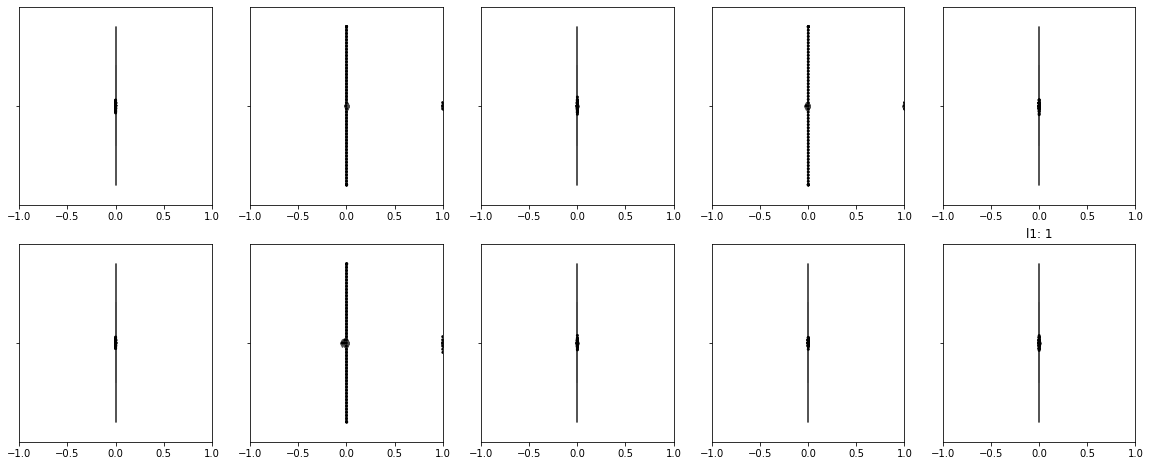

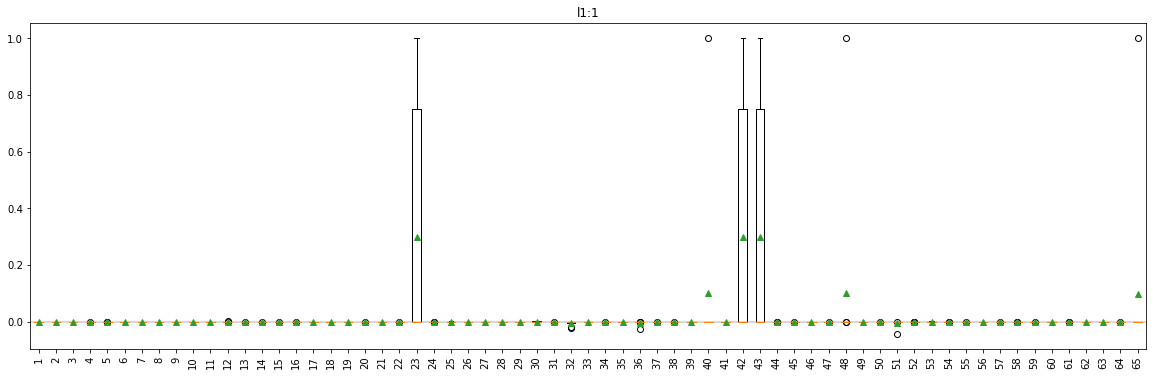

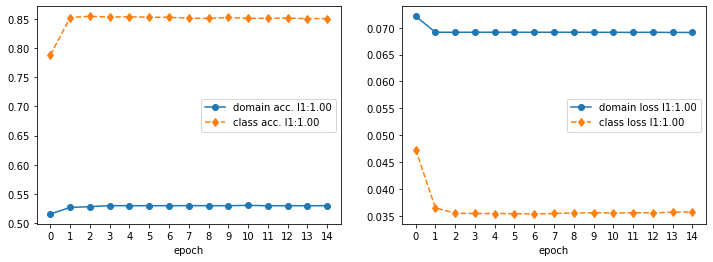

In [29]:
'''Model with L1 and L2 regularizations with linear increase in penalty'''
reduced_model_gender = oulad_helper.train_model(l1_weight = 1, l1_mul=1, l1_ann=True, l2_weight = 0.1, 
                                              ortho_weight=0, lasso=False, n_epochs=15, 
                                              df=semester_feature_df, predictors=semester_level_preds, 
                                              outcome='final_result_num', sensitive_attr='gender_num',
                                              show_plots=True
                                      )

(-1.2, 1.2)

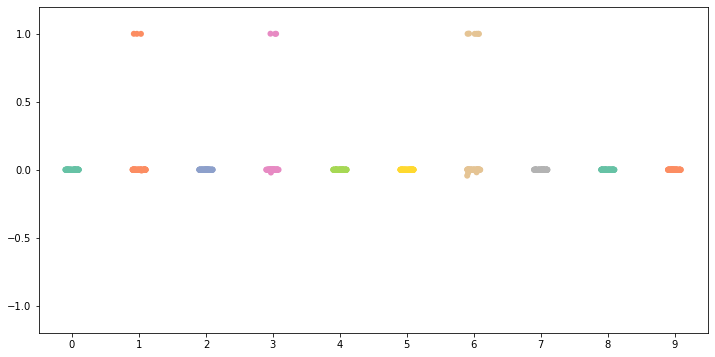

In [94]:
params = list(reduced_model_gender.lt.parameters())[0].detach().numpy()
plt.figure(figsize=(12,6))
sns.stripplot(data=params.T, orient='v', palette="Set2", size=6, edgecolor='black')
plt.ylim([-1.2,1.2])

In [95]:
params = binarize(params, threshold=.3)
final_preds = []
for i in range(params.shape[0]):
    print('node:', i+1)
    for j in range(params.shape[1]):
        p = params[i][j]
        if p==1:
            print('\t{} {}'.format('+', semester_level_preds[j]))
            final_preds.append(semester_level_preds[j])

print()
print('len(final_params)', len(set(final_preds)))
print(list(set(final_preds)))

node: 1
node: 2
	+ block_count
	+ session_count_homepage
	+ perc_interacted_quiz
node: 3
node: 4
	+ block_count
	+ session_count_homepage
	+ perc_interacted_quiz
node: 5
node: 6
node: 7
	+ block_count
	+ perc_interacted_subpage
	+ session_count_homepage
	+ perc_interacted_quiz
	+ perc_interacted_oucontent
	+ perc_interacted_externalquiz
node: 8
node: 9
node: 10

len(final_params) 6
['block_count', 'perc_interacted_oucontent', 'perc_interacted_subpage', 'session_count_homepage', 'perc_interacted_quiz', 'perc_interacted_externalquiz']


In [32]:
semester_feature_df['combined_feat'] = semester_feature_df[final_preds].sum(axis=1)
semester_feature_df.head(2)[final_preds+['combined_feat']]

,block_count,session_count_homepage,perc_interacted_quiz,block_count,session_count_homepage,perc_interacted_quiz,block_count,perc_interacted_subpage,session_count_homepage,perc_interacted_quiz,perc_interacted_oucontent,perc_interacted_externalquiz,combined_feat
row_id,,,,,,,,,,,,,
79461_CCC_2014B,6,45,62.499996,6,45,62.499996,6,28.571428,45,62.499996,0.000000,0.0,369.071416
2356809_BBB_2013J,6,95,99.999980,6,95,99.999980,6,42.105262,95,99.999980,99.999967,0.0,745.105169


In [33]:
'''How well the final features and their combination works'''
std_feats = semester_feature_df[final_preds].apply(stats.zscore)
std_feats['gender_num']=semester_feature_df.gender_num
std_feats['final_result_num']=semester_feature_df.final_result_num

ml_helper_methods.test_logit_model_accuracy(
    std_feats, predictors = final_preds, label = 'final_result_num', max_iter=50000)

ml_helper_methods.test_logit_model_accuracy(
    std_feats, predictors = final_preds, label = 'gender_num', max_iter=50000)


        Accuracy:86.55
        Precision:[0.86934673 0.86258741]
        Recall:[0.82883275 0.89611333]
        F1:[0.84860647 0.87903082]
        support:[2296 2753]
Confusion matrix:
[[1903  393]
 [ 286 2467]]
        Accuracy:63.54
        Precision:[0.62355095 0.65725579]
        Recall:[0.7710298 0.4854045]
        F1:[0.68949233 0.55840729]
        support:[2651 2398]
Confusion matrix:
[[2044  607]
 [1234 1164]]


LogisticRegression(C=1, max_iter=50000, penalty='none', random_state=0)

In [34]:
std_feats['combined_feat'] = std_feats[final_preds].sum(axis=1)
ml_helper_methods.test_logit_model_accuracy(
    semester_feature_df, predictors = ['combined_feat'], label = 'final_result_num', max_iter=50000)

ml_helper_methods.test_logit_model_accuracy(
    semester_feature_df, predictors = ['combined_feat'], label = 'gender_num', max_iter=50000)

        Accuracy:84.65
        Precision:[0.83195111 0.85859318]
        Recall:[0.83013937 0.86015256]
        F1:[0.83104426 0.85937216]
        support:[2296 2753]
Confusion matrix:
[[1906  390]
 [ 385 2368]]
        Accuracy:52.51
        Precision:[0.52505447 0.        ]
        Recall:[1. 0.]
        F1:[0.68857143 0.        ]
        support:[2651 2398]
Confusion matrix:
[[2651    0]
 [2398    0]]


/data/rakhasan/py37-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(C=1, max_iter=50000, penalty='none', random_state=0)

In [96]:
semester_feature_df[['perc_interacted_homepage']]

,perc_interacted_homepage
row_id,
79461_CCC_2014B,99.9999
2356809_BBB_2013J,99.9999
563763_DDD_2014B,99.9999
75091_AAA_2013J,99.9999
696364_FFF_2014J,99.9999
...,...
150578_DDD_2013B,99.9999
2518617_DDD_2013B,99.9999
679801_EEE_2014J,99.9999


#### Repeat training with non-zero predictors and each predictor is fed in a single node in the first hidden layer

In [35]:
'''
Workflow:
    -Create an weight mask for the LT layer 
    -In forward(): multiply the weight matrix with the mask to create masked weights and then compute outputs
    -Constrain parameters in the LT layer to be in {0,1}
'''

'\nWorkflow:\n    -Create an weight mask for the LT layer \n    -In forward(): multiply the weight matrix with the mask to create masked weights and then compute outputs\n    -Constrain parameters in the LT layer to be in {0,1}\n'

In [36]:
predictors=non_zero_preds
batch_size = 10
data = semester_feature_df
n_batches = math.ceil(len(data)/batch_size)
sensitive_labels = torch.Tensor(data['gender_num'].values)
outcome_labels = torch.Tensor(data['final_result_num'].values)
#create data loader    
data_tensor = data_utils.TensorDataset(torch.Tensor(data[predictors].values), 
                            outcome_labels, sensitive_labels)
data_loader = data_utils.DataLoader(data_tensor, 
                batch_size=batch_size, shuffle=True)

NameError: name 'non_zero_preds' is not defined

In [ ]:
mask_model = oulad_helper.FeatExtractorGR_Mask(dim_in=len(predictors), lt_dim=len(predictors)).to(device)
mask_model.lt.weight.size()

In [ ]:
reduced_model_masked = oulad_helper.train_model(model=mask_model, lasso=False, lt_dim=len(non_zero_preds), 
                            l1_weight = 1, l1_mul=10, l1_ann=True, l2_weight = 0.1,  n_epochs=15,
                        df=semester_feature_df, predictors=non_zero_preds, 
                        outcome='final_result_num', sensitive_attr='gender_num', show_plots=True)

In [ ]:
params = list(reduced_model_masked.lt.parameters())[0].detach().numpy()
plt.figure(figsize=(12,6))
sns.stripplot(data=params.T, orient='v', palette="Set2", size=6, edgecolor='black')
plt.ylim([-1.2,1.2])

discrete_params = np.zeros(params.shape)
for i in range(params.shape[0]):
    for j in range(params.shape[1]):
        if params[i][j]>.5:
            discrete_params[i][j]= 1            
plt.figure(figsize=(12,6))
sns.stripplot(data=discrete_params.T, orient='v', palette="Set2", size=6)
plt.ylim([-1.2,1.2])

In [ ]:
discrete_params = np.zeros(params.shape)
for i in range(params.shape[0]):
    for j in range(params.shape[1]):
        if params[i][j]>.5:
            discrete_params[i][j]= 1            
plt.figure(figsize=(12,6))
sns.stripplot(data=discrete_params.T, orient='v', palette="Set2", size=6)
plt.ylim([-1.2,1.2])

In [ ]:
from collections import Counter
counts = []
for i in range(discrete_params.shape[0]):
    print('node:', i+1)
    for j in range(discrete_params.shape[1]):
        p = discrete_params[i][j]
        if p!=0:
            print('\t{} {}'.format('+' if p>0 else '-', non_zero_preds[j]))
            counts.append(non_zero_preds[j])

print()
print(len(set(counts)))
print((Counter(counts).most_common()))

In [ ]:
ml_helper_methods.test_logit_model_accuracy(
    std_feats, predictors = ['combined_feat'], label = 'final_result_num', max_iter=50000)

ml_helper_methods.test_logit_model_accuracy(
    std_feats, predictors = ['combined_feat'], label = 'gender_num', max_iter=50000)

In [ ]:
ml_helper_methods.get_OR(ml_helper_methods.get_logit_model(
                        data=std_feats,
                        predictors= final_preds,
                        label='final_result_num',
                        l1_lambda=.00000))

### Custom models for age prediction

In [ ]:
semester_feature_df.groupby('age_num').count()

In [ ]:
'''undersample the majority class'''
age_balanced_df = semester_feature_df[semester_feature_df.age_num==0]
age_balanced_df = pd.concat([age_balanced_df, 
                             semester_feature_df[semester_feature_df.age_num==1].sample(len(age_balanced_df))])

age_balanced_df = age_balanced_df.sample(frac=1)
age_balanced_df.groupby('age_num').count()

In [ ]:
ml_helper_methods.test_logit_model_accuracy(
    age_balanced_df, predictors =semester_level_preds, label = 'age_num', max_iter=50000)

In [ ]:
'''Train a custom model to predict age group'''
oulad_helper.train_outcome_predictor(data=age_balanced_df, predictors=semester_level_preds, 
                                     outcome_col='age_num', batch_size = 10, n_epochs=10)

In [ ]:
13.4/.50

In [ ]:
'''constrain weights to be {0,1}'''
reduced_model_age = oulad_helper.train_model(l1_weight = 1, l2_weight = 0.1, ortho_weight=0, l1_ann=True, 
                                       lasso=False, l1_mul=2, lambda_=.3,
                                       n_epochs=15, df=age_balanced_df, predictors=semester_level_preds, 
                                       outcome='final_result_num', sensitive_attr='age_num',show_plots=True
                                      )

In [ ]:
params = list(reduced_model_age.lt.parameters())[0].detach().numpy()
plt.figure(figsize=(12,6))
sns.stripplot(data=params.T, orient='v', palette="Set2", size=6, edgecolor='black')
plt.ylim([-1.2,1.2])

In [ ]:
params = list(reduced_model_age.lt.parameters())[0].detach().numpy()
plt.figure(figsize=(12,6))
sns.stripplot(data=params.T, orient='v', palette="Set2", size=6, edgecolor='black')
plt.ylim([-1.2,1.2])

params = binarize(params, threshold=.3)
final_preds = []
for i in range(params.shape[0]):
    print('node:', i+1)
    for j in range(params.shape[1]):
        p = params[i][j]
        if p==1:
            print('\t{} {}'.format('+', semester_level_preds[j]))
            final_preds.append(semester_level_preds[j])

print()
print('len(final_params)', len(set(final_preds)))
print(list(set(final_preds)))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight(class_weight = 'balanced', 
                     classes = np.unique(semester_feature_df.age_num.values), 
                     y = semester_feature_df.age_num.values)

## Matching

### conduct PCA to prepare data for matching

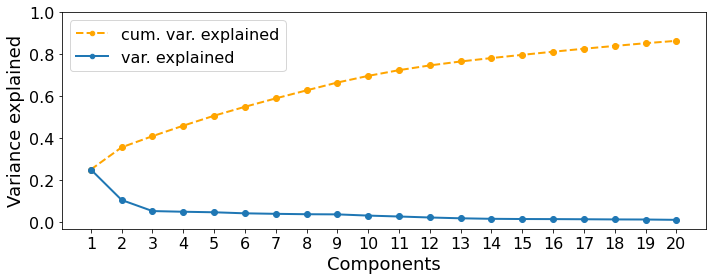

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,gender_num,previously_attempted,highest_education,credits,final_result_num
row_id,,,,,,,,,,,,,,,
79461_CCC_2014B,-2.156436,-0.712256,0.927591,0.001962,-0.352875,-0.032444,-0.661370,0.019240,-0.404600,-0.266026,0,False,2,90,0
2356809_BBB_2013J,0.008548,1.988990,1.947431,0.137798,-0.439040,-0.192550,-0.618259,0.033823,0.862873,1.675758,1,False,2,60,1
563763_DDD_2014B,0.064624,3.453687,-1.922669,0.468042,-2.351116,-0.139312,0.990663,1.649231,1.610351,-0.581702,1,False,1,60,1
75091_AAA_2013J,2.323188,-0.033563,0.557098,0.510094,0.526650,-0.155099,-0.329546,-0.576534,0.327861,1.231254,0,False,2,60,1
696364_FFF_2014J,1.926408,-0.671957,-0.022697,5.580213,0.107934,0.441577,0.118943,0.060755,-0.496346,-2.061514,0,False,2,60,1


In [152]:
n_comp=20
pca = PCA(n_components=n_comp).fit(semester_feature_df[semester_level_preds].apply(stats.zscore).values)
plot_helper_methods.plot_scree(n_comp, pca, figsize=(10,4))

'''set n_comp based on the plot and get transformed data'''
n_comp=10
comp_names = ['pc_{}'.format(i) for i in range(1,n_comp+1)]
pca_transformed = PCA(n_components=n_comp).fit_transform(
                        semester_feature_df[semester_level_preds].apply(stats.zscore).values)
pca_transformed_df = pd.DataFrame(pca_transformed, columns=comp_names, 
                                  index=semester_feature_df.index)
# pca_transformed_df['final_result_num']=semester_feature_df.final_result_num
pca_transformed_df['gender_num']=semester_feature_df.gender_num
pca_transformed_df['previously_attempted']=semester_feature_df.previously_attempted
pca_transformed_df['highest_education']=semester_feature_df.highest_education
pca_transformed_df['credits']=semester_feature_df.credits
pca_transformed_df['final_result_num']=semester_feature_df.final_result_num
pca_transformed_df.to_csv(join(data_root,'pca_transformed_df.csv'))
pca_transformed_df.head()

In [141]:
'''test for difference across gender before matching'''
contingency_table = pd.crosstab(index=semester_feature_df['gender_num'],
                                columns=semester_feature_df['final_result_num'])
print(contingency_table)
'''test for difference across gender before matching'''
chi, p, dof, expected = stats.chi2_contingency(contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}, dof:{:.2f}'.format(chi, p, dof))

print()
proportions_ztest([len(semester_feature_df[(semester_feature_df.gender_num==1) & (semester_feature_df.final_result_num==1)]), 
                  len(semester_feature_df[(semester_feature_df.gender_num==0) & (semester_feature_df.final_result_num==1)])], 
                  [len(semester_feature_df[semester_feature_df.gender_num==1]), len(semester_feature_df[semester_feature_df.gender_num==0])])

final_result_num     0     1
gender_num                  
0                 6591  6783
1                 5183  6688
chi:79.85, p:0.000, dof:1.00



(8.935657776521314, 4.04762967464304e-19)

In [162]:
'''load matched pairs (mahalanobis distance matching with replacement)'''
maha_matches = pd.read_csv(join(data_root,'maha-matched-pairs-rep.csv'),sep=';')
maha_matches = maha_matches.loc[:, ~maha_matches.columns.str.contains('^Unnamed')]
print(len(maha_matches), len(set(maha_matches.female)), len(set(maha_matches.male)))
maha_matches.dropna(inplace=True)
print(len(maha_matches), len(set(maha_matches.female)), len(maha_matches.male), len(set(maha_matches.male)))
maha_matches.head(2)

11871 11871 5027
11871 11871 11871 5027


,female,male
0,2356809_BBB_2013J,583170_BBB_2013J
1,563763_DDD_2014B,630774_DDD_2014B


In [189]:
''' tests for gender effect within for matched samples'''
matched_df = pca_transformed_df.loc[list(set(maha_matches.female))+list(maha_matches.male)]
print("***** without removing duplicates ****")
matched_contingency_table = pd.crosstab(index=matched_df['gender_num'],
                                columns=matched_df['final_result_num'])
print(matched_contingency_table)

chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}, dof:{}'.format(chi, p, dof))

print("\n***** after removing duplicates ****")
matched_df_nodup = matched_df[~matched_df.index.duplicated()]
print('sample size:',len(matched_df_nodup))
matched_contingency_table = pd.crosstab(index=matched_df_nodup['gender_num'],
                                columns=matched_df_nodup['final_result_num'])
print(matched_contingency_table)

chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}, dof:{}'.format(chi, p, dof))


***** without removing duplicates ****
final_result_num     0     1
gender_num                  
0                 5248  6623
1                 5183  6688
chi:0.72, p:0.395, dof:1

***** after removing duplicates ****
sample size: 16898
final_result_num     0     1
gender_num                  
0                 2534  2493
1                 5183  6688
chi:64.79, p:0.000, dof:1


<AxesSubplot:xlabel='tsne-1d', ylabel='tsne-2d'>

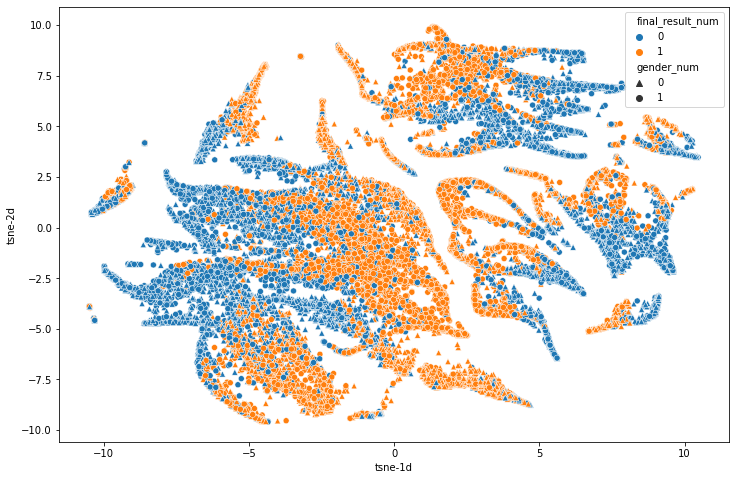

In [208]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_transformed_df[comp_names+['previously_attempted', 
                                                'highest_education', 'credits']].values)
pca_transformed_df['tsne-1d'] = tsne_results[:,0]
pca_transformed_df['tsne-2d'] = tsne_results[:,1]

plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="final_result_num",
    style='gender_num',
    markers=['^', 'o'],
    data=pca_transformed_df,
    legend="full"
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 23742 samples in 0.487s...
[t-SNE] Computed neighbors for 23742 samples in 4.592s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23742
[t-SNE] Computed conditional probabilities for sample 2000 / 23742
[t-SNE] Computed conditional probabilities for sample 3000 / 23742
[t-SNE] Computed conditional probabilities for sample 4000 / 23742
[t-SNE] Computed conditional probabilities for sample 5000 / 23742
[t-SNE] Computed conditional probabilities for sample 6000 / 23742
[t-SNE] Computed conditional probabilities for sample 7000 / 23742
[t-SNE] Computed conditional probabilities for sample 8000 / 23742
[t-SNE] Computed conditional probabilities for sample 9000 / 23742
[t-SNE] Computed conditional probabilities for sample 10000 / 23742
[t-SNE] Computed conditional probabilities for sample 11000 / 23742
[t-SNE] Computed conditional probabilities for sample 12000 / 23742
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='tsne-1d', ylabel='tsne-2d'>

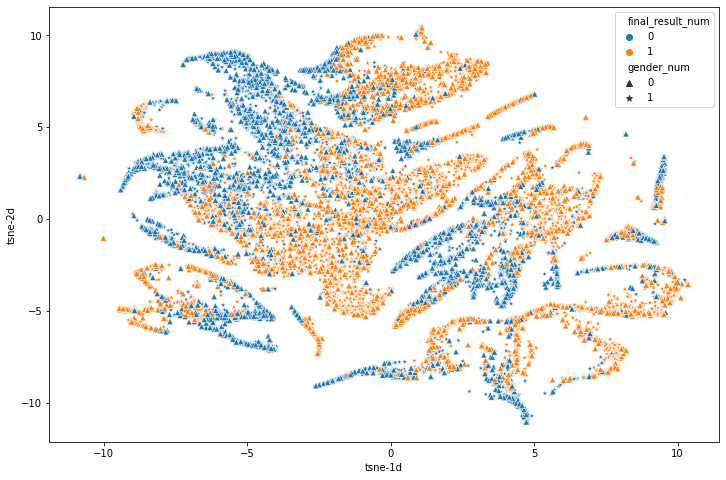

In [213]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(matched_df[comp_names+['previously_attempted', 
                                                'highest_education', 'credits']].values)
matched_df['tsne-1d'] = tsne_results[:,0]
matched_df['tsne-2d'] = tsne_results[:,1]

plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="final_result_num",
    style='gender_num',
    markers=['^', '*'],
    data=matched_df,
    legend="full"
)

In [196]:
len(matched_df_nodup[(matched_df_nodup.gender_num==0) & (matched_df_nodup.final_result_num==1)])

2493

In [201]:
tab = [ 
        [len(matched_df[matched_df.final_result_num==0]),
        len(matched_df[(matched_df.gender_num==1) & (matched_df.final_result_num==1)])],
        [len(matched_df[(matched_df.gender_num==0) & (matched_df.final_result_num==1)]),
        len(matched_df[matched_df.final_result_num==1])]
    ]
tab

[[10431, 6688], [6623, 13311]]

In [202]:
res=statsmodels.stats.contingency_tables.mcnemar(table=tab, exact=False, correction=False)
print(res)

pvalue      0.573170333545398
statistic   0.31740665614904967


In [ ]:
'''plot SMD'''
covs = ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9',
       'pc_10', 'previously_attempted', 'highest_education', 'credits']
cov_names=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9',
       'PC10', 'Repeated', 'Highest edu.', 'Credits']
matched_smds=[]
unmatched_smds=[]
for cov in covs:
    if cov=='gender_num':
        continue
    means = pca_transformed_df.groupby('gender_num')[cov].mean()
    var = pca_transformed_df.groupby('gender_num')[cov].var()
    smd = np.fabs(means[0]-means[1])/((var[0]+var[1])/2)**.5
    unmatched_smds.append(smd)
    
    means = matched_df.groupby('gender_num')[cov].mean()
    var = matched_df.groupby('gender_num')[cov].var()
    smd = np.fabs(means[0]-means[1])/((var[0]+var[1])/2)**.5
    matched_smds.append(smd)
    
smd_df = pd.DataFrame({'unmatched': unmatched_smds,
                   'matched': matched_smds}, index=cov_names)
ax = smd_df.plot.barh(rot=0, color=colors, width=.9)

plt.xticks( fontsize=tickFont-4)
plt.xlabel('Absolute standardized mean difference', fontsize=labelFont-4)
plt.yticks(fontsize=tickFont-4)


background=".9"
ax.set_facecolor(background)

plt.setp(ax.spines.values(), color=background)
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=background)
plt.legend(fontsize=labelFont-4, facecolor=".95", loc='upper right')
plt.tight_layout()
plt.savefig("/data/rakhasan/edtech-smd.pdf",dpi=600)
plt.show()

In [ ]:
'''test for difference across age before matching'''
contingency_table = pd.crosstab(index=semester_feature_df['age_num'],
                                columns=semester_feature_df['final_result_num'])
print(contingency_table)
'''test for difference across gender before matching'''
chi, p, dof, expected = stats.chi2_contingency(contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}'.format(chi, p))

In [ ]:
'''test for gender within matched sample after removing duplicate matches'''
print(maha_matches.shape)
no_dup = maha_matches.set_index('male')
no_dup=no_dup[~no_dup.index.duplicated(keep='first')]
no_dup.reset_index(inplace=True)
print(no_dup.shape)
matched_df = semester_feature_df.loc[list(set(no_dup.female))+list(set(no_dup.male))]
matched_contingency_table = pd.crosstab(index=matched_df['gender_num'],
                                columns=matched_df['final_result_num'])

chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}'.format(chi, p))
matched_contingency_table

In [ ]:
''' tests for age effect within for matched samples'''
import statsmodels
matched_contingency_table = pd.crosstab(index=matched_df['age_num'],
                                columns=matched_df['final_result_num'])
print(matched_contingency_table)
chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}'.format(chi, p))


In [ ]:
matched_contingency_table = pd.crosstab(index=matched_df['age_num'],
                                columns=matched_df['final_result_num'])

chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}'.format(chi, p))
matched_contingency_table

### Robustness check

In [ ]:
'''
Train the reduced model 10 times with different random seeds
'''
all_features=[]
for s in range(0,10):
    random.seed(s)
    torch.manual_seed(s)
    np.random.seed(s)

    reduced_model_gender = oulad_helper.train_model(l1_weight = 1, l1_mul=2, l1_ann=True, l2_weight = 0.1, 
                                                  ortho_weight=0, lasso=False, n_epochs=15, 
                                                  df=semester_feature_df, predictors=semester_level_preds, 
                                                  outcome='final_result_num', sensitive_attr='gender_num',
                                                  show_plots=True
                                          )
    params = binarize(params, threshold=.3)
    final_params = []
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):
            p = params[i][j]
            if p==1:
                final_params.append(semester_level_preds[j])

    all_features.append(set(final_params))
    
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
feat=all_features[0]
print(len(feat),feat)
for f in all_features[1:]:
    print(set(f).difference(feat))

In [ ]:
set(feat)

## Predict dropout in OULAD

In [100]:
semester_feature_df['final_result'] = semester_feature_df.apply(lambda row: student_df.loc[int(row.name.split('_')[0])].final_result, axis=1)

In [101]:
semester_feature_df.groupby('final_result').count()

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,mean_block_len,var_block_len,gender_num,final_result_num,credits,highest_education,previously_attempted,age_num,edu_bin,combined_feat
final_result,,,,,,,,,,,,,,,,,,,,,
Distinction,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,...,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645
Fail,5779,5779,5779,5779,5779,5779,5779,5779,5779,5779,...,5779,5779,5779,5779,5779,5779,5779,5779,5779,5779
Pass,10826,10826,10826,10826,10826,10826,10826,10826,10826,10826,...,10826,10826,10826,10826,10826,10826,10826,10826,10826,10826
Withdrawn,5995,5995,5995,5995,5995,5995,5995,5995,5995,5995,...,5995,5995,5995,5995,5995,5995,5995,5995,5995,5995


In [102]:
semester_feature_df['dropout']=semester_feature_df.apply(lambda row: int(row.final_result=='Withdrawn'), axis=1)

In [103]:
dropout_df = semester_feature_df[semester_feature_df.dropout==1]
dropout_df = pd.concat([dropout_df, semester_feature_df[semester_feature_df.dropout==0].sample(len(dropout_df))])

In [121]:
len(semester_feature_df[semester_feature_df.dropout==1]), dropout_df.shape

(5995, (11990, 76))

In [105]:
dropout_df.groupby('dropout').count()/len(dropout_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,var_block_len,gender_num,final_result_num,credits,highest_education,previously_attempted,age_num,edu_bin,combined_feat,final_result
dropout,,,,,,,,,,,,,,,,,,,,,
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [106]:
dropout_df.groupby('gender_num').count()/len(dropout_df)

,session_count_dataplus,session_count_dualpane,session_count_externalquiz,session_count_folder,session_count_forumng,session_count_glossary,session_count_homepage,session_count_htmlactivity,session_count_oucollaborate,session_count_oucontent,...,var_block_len,final_result_num,credits,highest_education,previously_attempted,age_num,edu_bin,combined_feat,final_result,dropout
gender_num,,,,,,,,,,,,,,,,,,,,,
0,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,...,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829,0.54829
1,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,...,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171,0.45171


In [107]:
'''How well the dropout can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy( dropout_df, predictors = semester_level_preds, 
                                    label = 'dropout', average='weighted', class_weight=None, max_iter=10000)

        Accuracy:84.40
        Precision:0.8444008340507004
        Recall:0.8440366972477065
        F1:0.843933934873422
        support:None
Confusion matrix:
[[ 969  209]
 [ 165 1055]]


LogisticRegression(C=1, max_iter=10000, penalty='none', random_state=0)

In [108]:
'''How well the gender can be predicted using all features'''
ml_helper_methods.test_logit_model_accuracy( dropout_df, predictors = semester_level_preds, 
                                    label = 'gender_num', average='weighted', class_weight=None, max_iter=10000)

        Accuracy:69.14
        Precision:0.7028336005197268
        Recall:0.6914095079232694
        F1:0.6825557908950669
        support:None
Confusion matrix:
[[1065  202]
 [ 538  593]]


LogisticRegression(C=1, max_iter=10000, penalty='none', random_state=0)

### Matching

In [113]:
'''test for difference across gender before matching'''
contingency_table = pd.crosstab(index=semester_feature_df['gender_num'],
                                columns=semester_feature_df['dropout'])
print(contingency_table)
'''test for difference across gender before matching'''
chi, p, dof, expected = stats.chi2_contingency(contingency_table, correction=False)
print('chi:{:.2f}, p:{:.4f}'.format(chi, p))

dropout        0     1
gender_num            
0           9935  3439
1           9315  2556
chi:60.76, p:0.0000


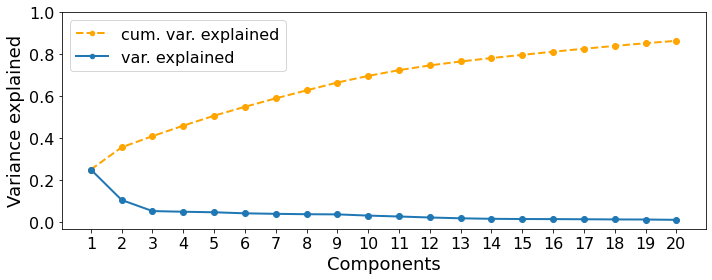

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,gender_num,previously_attempted,highest_education,credits
row_id,,,,,,,,,,,,,,
79461_CCC_2014B,-1.550360,-0.418891,-1.474710,0.144559,-0.371029,0.104001,-0.997949,-0.132249,-0.079315,-0.131900,0,False,2,90
2336922_DDD_2013J,-0.850178,1.606881,1.473207,-0.362500,-0.686828,0.044530,1.116225,0.295051,0.359191,-0.315011,1,False,2,180
2569834_CCC_2014B,-2.677278,-0.691360,0.193373,0.191210,0.096134,-0.104420,-0.032927,0.065457,-0.459243,-0.097469,1,False,2,60
184627_FFF_2013J,-1.489898,-1.203361,0.689263,0.075732,-0.022860,-0.102672,0.505215,-0.056747,0.000217,0.193952,1,True,3,90
652667_EEE_2014J,-3.199436,-1.000751,0.537116,0.341239,0.465173,-0.162182,0.284499,-0.269001,-0.051995,0.058144,0,False,1,120


In [114]:
n_comp=20
pca = PCA(n_components=n_comp).fit(semester_feature_df[semester_level_preds].apply(stats.zscore).values)
plot_helper_methods.plot_scree(n_comp, pca, figsize=(10,4))

'''set n_comp based on the plot and get transformed data'''
n_comp=10
comp_names = ['pc_{}'.format(i) for i in range(1,n_comp+1)]
pca_transformed = PCA(n_components=n_comp).fit_transform(
                        dropout_df[semester_level_preds].apply(stats.zscore).values)
pca_transformed_df = pd.DataFrame(pca_transformed, columns=comp_names, 
                                  index=dropout_df.index)
pca_transformed_df['gender_num']=semester_feature_df.gender_num
pca_transformed_df['previously_attempted']=semester_feature_df.previously_attempted
pca_transformed_df['highest_education']=semester_feature_df.highest_education
pca_transformed_df['credits']=semester_feature_df.credits
pca_transformed_df.to_csv(join(data_root,'pca_transformed_dropout_df.csv'))
pca_transformed_df.head()

In [131]:
'''load matched dataset'''
maha_matches = pd.read_csv(join(data_root,"maha-matched-pairs-rep-dropout.csv"),sep=';')
maha_matches = maha_matches.loc[:, ~maha_matches.columns.str.contains('^Unnamed')]
print(len(maha_matches), len(set(maha_matches.female)), len(set(maha_matches.male)))
maha_matches.dropna(inplace=True)
print(len(maha_matches), len(set(maha_matches.female)), len(set(maha_matches.male)))
maha_matches.head(2)


5416 5416 2575
5416 5416 2575


,female,male
0,2336922_DDD_2013J,68011_DDD_2013J
1,2569834_CCC_2014B,633432_CCC_2014B


In [132]:
''' tests for gender effect  for matched samples for dropout'''

#first, remove duplicate males
maha_matches = maha_matches.set_index('male')
maha_matches =  maha_matches[~maha_matches.index.duplicated(keep='first')].reset_index()
indx = (set(maha_matches.female).union(maha_matches.male))#.intersection(dropout_df.index)
print(len(indx))
matched_df = dropout_df.loc[indx]
matched_contingency_table = pd.crosstab(index=matched_df['gender_num'],
                                columns=matched_df['dropout'])
print(matched_contingency_table)

chi, p, dof, expected = stats.chi2_contingency(matched_contingency_table, correction=False)
print('chi:{:.2f}, p:{:.3f}'.format(chi, p))

5150
dropout        0     1
gender_num            
0           1169  1406
1            971  1604
chi:31.34, p:0.000


In [135]:
matched_df.to_csv(join(data_root, 'matched-cov-dropout.csv'))
len(matched_df[matched_df.gender_num==0]),len(matched_df[matched_df.gender_num==1])

(2575, 2575)

### Custom models for dropout prediction

In [ ]:
'''simple model to predict gender'''
oulad_helper.train_outcome_predictor(data=dropout_df, predictors=semester_level_preds, 
                                     outcome_col='gender_num', batch_size = 10, n_epochs=15)

In [ ]:
'Model with gradient reversal but no linear transform layer'
gr_model_gender = oulad_helper.FeatExtractorGR(dim_in = len(semester_level_preds))

domain_acc, class_acc, domain_loss, class_loss = oulad_helper.train_feat_transformer(
        data=dropout_df,predictors=semester_level_preds, outcome_col='dropout',
        sensitive_attr_col='gender_num', model=gr_model_gender, n_epochs=15, #l1_weight = .1, l2_weight = .1,
        ortho_weight = 0, lasso=True, l1_mul=1, l1_ann= False)

In [ ]:
'''model with constraint optimization'''
reduced_model_gender = oulad_helper.train_model(l1_weight = 1, l1_mul=2, l1_ann=True, l2_weight = 0.1, 
                                              ortho_weight=0, lasso=False, n_epochs=15, 
                                              df=dropout_df, predictors=semester_level_preds, 
                                              outcome='dropout', sensitive_attr='gender_num',
                                              show_plots=True
                                      )


In [ ]:
params = list(reduced_model_gender.lt.parameters())[0].detach().numpy()
plt.figure(figsize=(12,6))
sns.stripplot(data=params.T, orient='v', palette="Set2", size=6, edgecolor='black')
plt.ylim([-1.2,1.2])

params = binarize(params, threshold=.3)
final_preds = []
for i in range(params.shape[0]):
    print('node:', i+1)
    for j in range(params.shape[1]):
        p = params[i][j]
        if p==1:
            print('\t{} {}'.format('+', semester_level_preds[j]))
            final_preds.append(semester_level_preds[j])

print()
print('len(final_params)', len(set(final_preds)))
print(list(set(final_preds)))